In [1]:
import pandas as pd
import numpy as np
import gudhi as gd
from gudhi.weighted_rips_complex import WeightedRipsComplex
from gudhi.point_cloud.timedelay import TimeDelayEmbedding
from gudhi.point_cloud.dtm import DistanceToMeasure
from gudhi.hera import wasserstein_distance
from gudhi.representations import PersistenceImage, BettiCurve
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from joblib import Parallel, delayed
from gudhi.representations.metrics import WassersteinDistance
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.manifold import MDS
import os
from scipy import stats
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist
from scipy import signal
from scipy.stats import levy_stable
from symulacja_py import impsim
from tqdm.auto import tqdm 
import h5py
#%matplotlib widget

In [2]:
datapath ="./data/dane vibstand/"
filelist = os.listdir(datapath)
print(sorted(filelist))
filenames  =sorted(filelist)
df_list = []
for filename in sorted(filelist):
    f = h5py.File(datapath +filename,'r')
    data_names = np.array(f.get('/'))
    dictionary = {}
    for i in range(0,len(data_names)-1):
        name = data_names[i]
        dictionary.update({name : np.array(f.get('/'+name)).T[0]})
    df = pd.DataFrame.from_dict(dictionary)
    df_list.append(df)

['speed_10.mat', 'speed_15.mat', 'speed_20.mat', 'speed_25_5.mat']


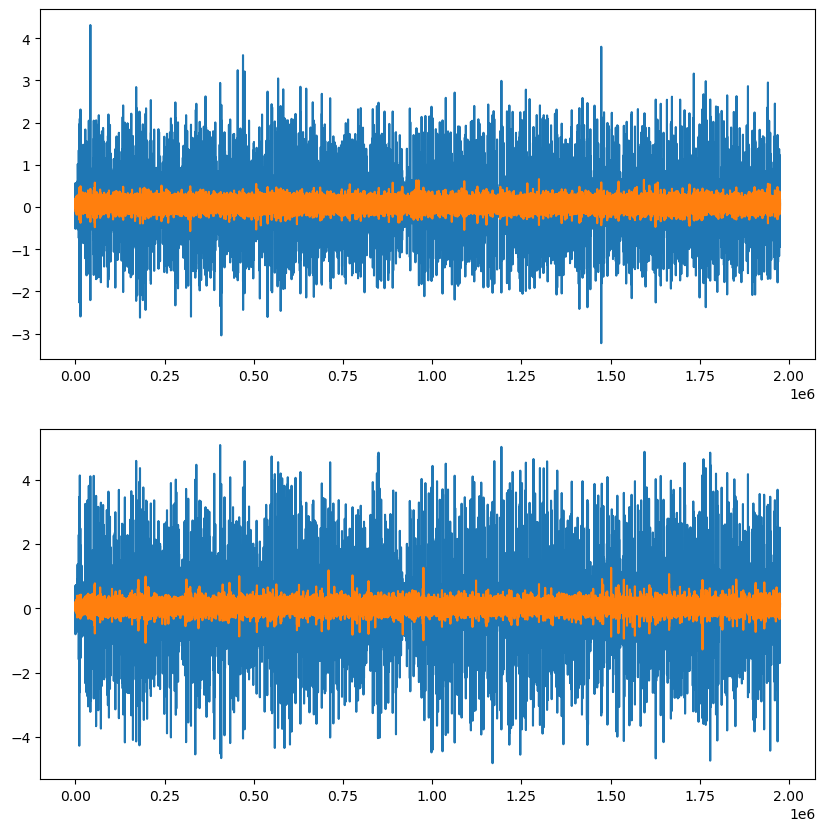

In [3]:
df = df_list[0]
f,ax = plt.subplots(2,1, figsize =(10,10))
ax[0].plot(df["Vib1"])
ax[0].plot(df["Vib3"])
ax[1].plot(df["Vib2"])
ax[1].plot(df["Vib4"])
plt.show()

In [2]:
start = 2.98
end = 3.7
grid = np.linspace(start,end,1000)

def compute_bc_from_ts(data, dim, delay, skip, normalize = True, weighted = True):
    #data = create_signal(alpha, amplitude, seed)
    #dim * delay should roughly equal len(time_series)/numer_of_periods
    #dim = 3*833#417# half period
    #delay = len(data)//dim
    #print("delay", delay)
    #skip = 1#200#0#100
    #print(dim*delay)
    #print(len(data[0])/24)

    #print("===============computing SWE====================")
    tde = TimeDelayEmbedding(dim = dim, delay=delay, skip=skip)
    point_clouds = tde.transform([data])[0]
    if len(point_clouds>100):
        skip = max(len(point_clouds)//100,1)
        tde = TimeDelayEmbedding(dim = dim, delay=delay, skip=skip)
        point_clouds = tde.transform([data])[0] 
    #point_clouds = levy_stable.rvs(alpha,0,0, size=(100,2))

    if (normalize):
        point_clouds = point_clouds-np.mean(point_clouds,1)[:, None]
        point_clouds = point_clouds/np.sqrt(np.sum(point_clouds**2, 1))[:, None]

    pc = point_clouds
    print(len(pc))

    if weighted:
        dist = cdist(pc,pc)
        dtm = DistanceToMeasure(5, dim = 10, q=2, metric="precomputed")
        r = dtm.fit_transform(dist)
        ac = WeightedRipsComplex(distance_matrix=dist,weights = 1/r)
    else:
        ac = gd.RipsComplex(points=pc)
    
    st = ac.create_simplex_tree(max_dimension = 2)
    st.compute_persistence()
    pd = st.persistence_intervals_in_dimension(1)

    bc = BettiCurve(predefined_grid=grid)
    betti_curve = bc.fit_transform([pd])
    return betti_curve[0]

In [29]:
betti_curves = []
base_length = 50000
for j in tqdm(range(0,len(df_list))):
    scaling_factor =(3.5-((j//4)+2)*0.5)
    length = int(base_length * scaling_factor)
    dim = int(723*scaling_factor)
    delay = 50000//dim
    
    skip =1
    for i in range(0,4):
        samples = np.array_split(df_list[j].iloc[:,i].values,40)
        bc = np.array([compute_bc_from_ts(s, dim, delay, skip) for s in samples])
        betti_curves.append(bc)

  0%|          | 0/4 [00:00<?, ?it/s]

103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
103
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101
101


ValueError: cannot reshape array of size 0 into shape (0,newaxis)

In [6]:
pca = PCA(n_components=3)
emb = pca.fit_transform(betti_curves)

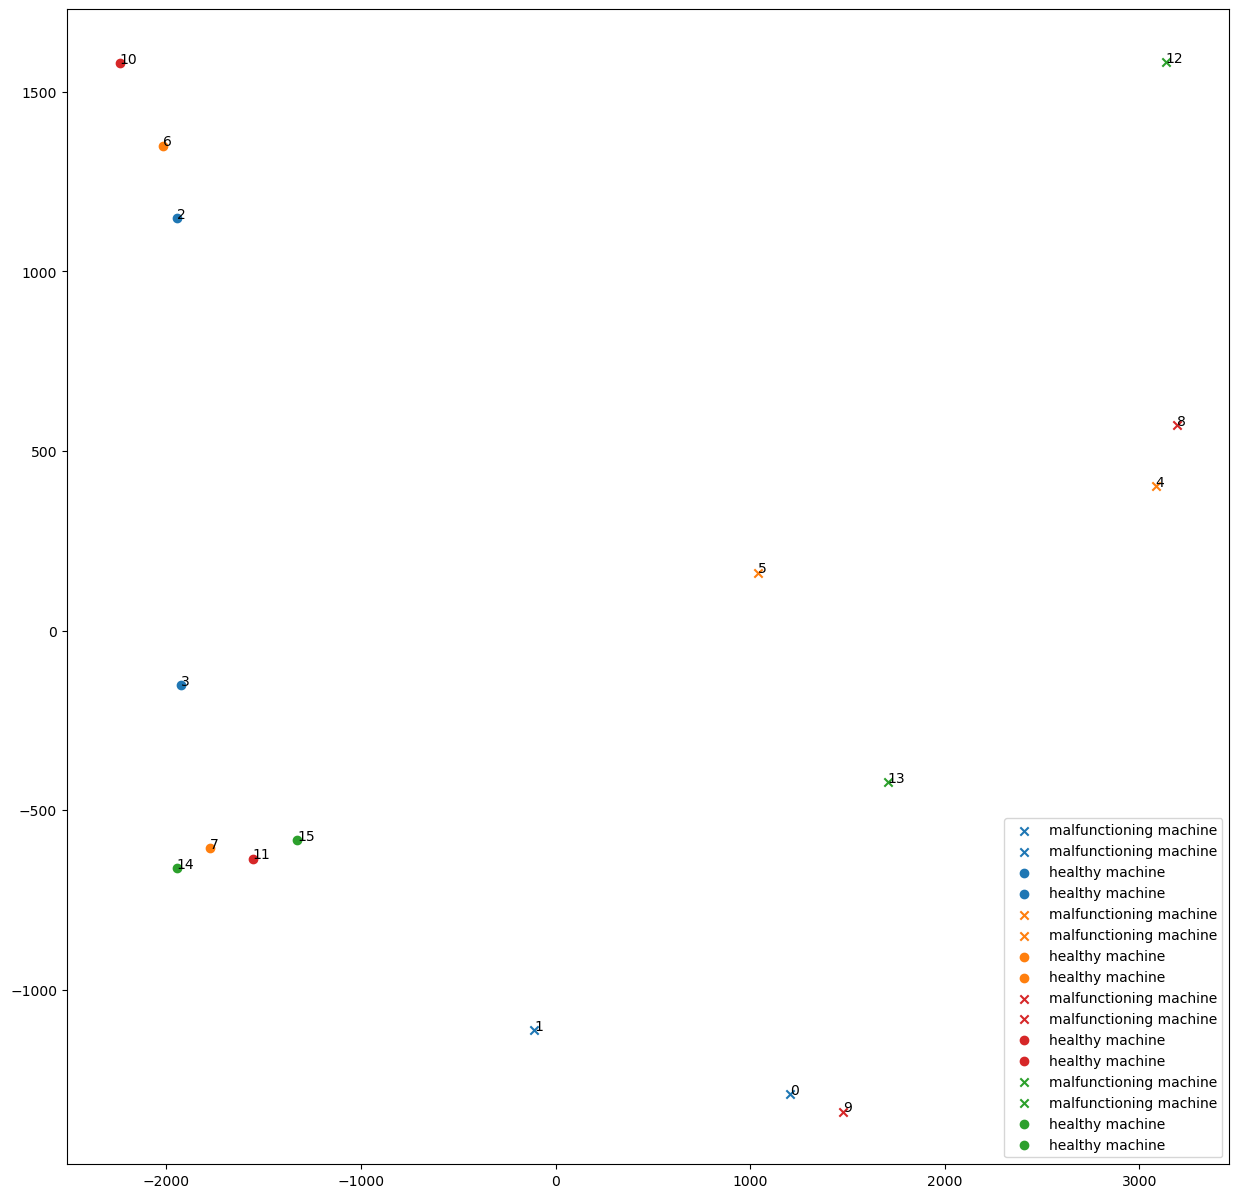

[0.70409312 0.16406381 0.06653587]


In [7]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot()
#ax.scatter(emb[:,0],emb[:,1])#,  marker = "o", c=t, label="malfunctioning machine {}".format(i))
colors = ["tab:blue", "tab:orange", "tab:red", "tab:green"]
for i in range(0,len(emb)):    
    if i%4 < 2:
        ax.scatter(emb[i,0],emb[i,1], marker = "x", c=colors[i//4], label="malfunctioning machine")
    elif i%4 > 1:
        ax.scatter(emb[i,0],emb[i,1], marker = "o", c=colors[i//4], label="healthy machine")
    
    ax.text(emb[i,0],emb[i,1], "{}".format(i))

#for i in range(mc_iterations):
    #ax.scatter(emb[21*i+20,0],emb[21*i+20,1], marker = "x", label="well-working machine")

#avg_emb = pca.transform(avg_bc)
#ax.scatter(avg_emb[:,0],avg_emb[:,1], c= range(0,21), marker="x")
ax.legend()
#plt.savefig("data221214_alpha18_PCA-from-PI_dim{}_delay{}.pdf".format(dim, delay))
#plt.colorbar()
plt.show()
print(pca.explained_variance_ratio_)

In [3]:
def number_significant_points(alpha, dgm):
    A = 1 #Rips
    loglogpi = np.log(np.log(dgm[:,1]/dgm[:,0]))
    B = -np.euler_gamma - A*np.mean(loglogpi)
    l_vals = A*loglogpi+B
    sig_pts = dgm[np.exp(-np.exp(l_vals))<alpha/len(dgm)]
    #print(l_vals)
    return (sig_pts)

def compute_significant_ph_from_ts(data, dim, delay, skip, normalize = True, weighted = True):
    #data = create_signal(alpha, amplitude, seed)
    #dim * delay should roughly equal len(time_series)/numer_of_periods
    #dim = 3*833#417# half period
    #delay = len(data)//dim
    #print("delay", delay)
    #skip = 1#200#0#100
    #print(dim*delay)
    #print(len(data[0])/24)

    #print("===============computing SWE====================")
    tde = TimeDelayEmbedding(dim = dim, delay=delay, skip=skip)
    point_clouds = tde.transform([data])[0]
    if len(point_clouds>300):
        skip = max(len(point_clouds)//300,1)
        tde = TimeDelayEmbedding(dim = dim, delay=delay, skip=skip)
        point_clouds = tde.transform([data])[0] 
    #point_clouds = levy_stable.rvs(alpha,0,0, size=(100,2))

    if (normalize):
        point_clouds = point_clouds-np.mean(point_clouds,1)[:, None]
        point_clouds = point_clouds/np.sqrt(np.sum(point_clouds**2, 1))[:, None]

    pc = point_clouds
    print(len(pc))

    if weighted:
        dist = cdist(pc,pc)
        dtm = DistanceToMeasure(5, dim = 10, q=2, metric="precomputed")
        r = dtm.fit_transform(dist)
        ac = WeightedRipsComplex(distance_matrix=dist,weights = 1/r)
    else:
        ac = gd.RipsComplex(points=pc)
    
    st = ac.create_simplex_tree(max_dimension = 2)
    st.compute_persistence()
    pd = st.persistence_intervals_in_dimension(1)
    #print(len(pd))

    return number_significant_points(0.1,pd)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

350
350
350
350


  0%|          | 0/4 [00:00<?, ?it/s]

350
350
350
350


  0%|          | 0/4 [00:00<?, ?it/s]

350
350
350
350


  0%|          | 0/4 [00:00<?, ?it/s]

350
350
350
350


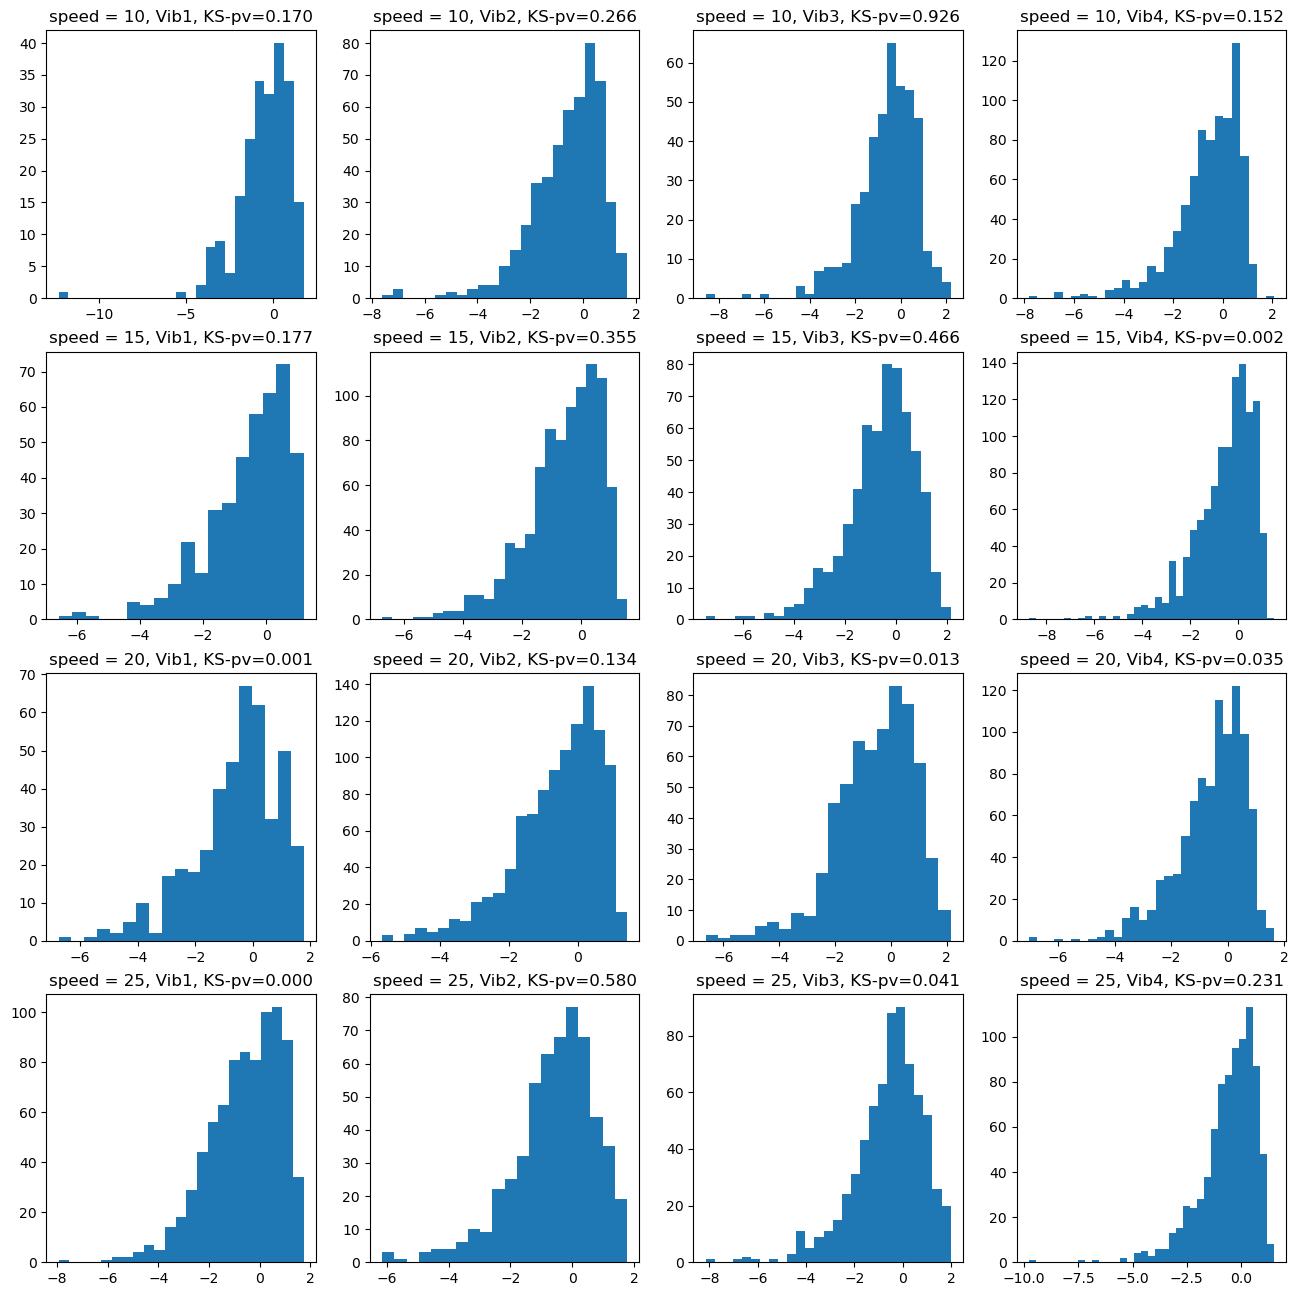

In [26]:
speeds = [10,15,20,25]
f, ax = plt.subplots(4,4,figsize = (16,16))
for j in tqdm(range(0,len(df_list))):
    scaling_factor =(3.5-((j//4)+2)*0.5)
    length = int(base_length * scaling_factor)
    dim = int(833*scaling_factor)
    delay = int((((j//4)+2)*0.5)*length)//dim
    skip =1
    
    for i in tqdm(range(0,len(bc))):
        score = compute_significant_ph_from_ts(df_list[j].iloc[:length,i].values, dim, delay, skip)
        ax[j][i].hist(score, bins="auto")
        ax[j][i].set_title("speed = {0}, Vib{1}, KS-pv={2:1.3f}".format(speeds[j], i+1,stats.kstest(score, "gumbel_l").pvalue))
plt.show()

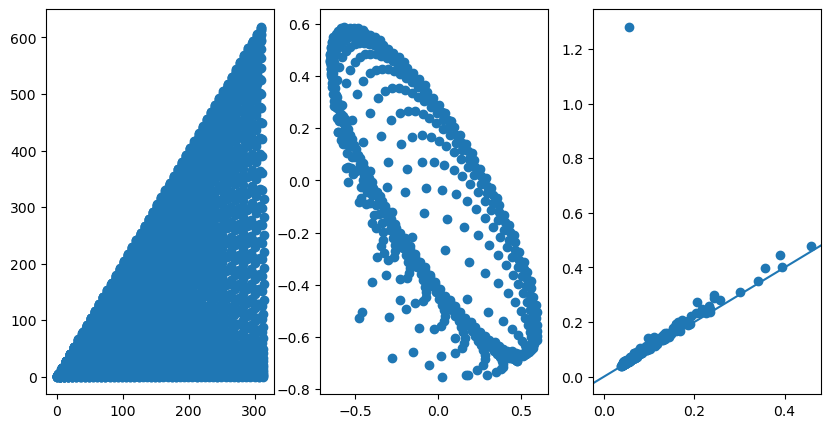

1


In [13]:
t = np.linspace(0,100*np.pi, 3141)
sine = np.sin(t)
rng = np.random.default_rng(seed=42)

noisy_signal = sine*t + 0.1*(rng.random(len(t))-0.5) +t
tde = TimeDelayEmbedding(dim = 5, delay=100, skip=5)
point_clouds = tde.transform([noisy_signal])[0]
point_clouds = point_clouds-np.mean(point_clouds,1)[:, None]
point_clouds = point_clouds/np.sqrt(np.sum(point_clouds**2, 1))[:, None]
pc = point_clouds
ac = gd.RipsComplex(points=pc)
    
st = ac.create_simplex_tree(max_dimension = 2)
st.compute_persistence()
pd = st.persistence_intervals_in_dimension(1)
f,ax = plt.subplots(1,3, figsize = (10,5))
ax[0].scatter(t,noisy_signal)
ax[1].scatter(pc[:,0],pc[:,1])
ax[2].scatter(pd[:,0],pd[:,1])
ax[2].axline((0,0),slope=1)
plt.show()
print(len(number_significant_points(0.05,pd)))

In [47]:
t = np.linspace(0,4*np.pi, 1200)
sine = np.sin(t)
noise_levels = np.linspace(0,2,50)
number_significant_bars = np.zeros_like(noise_levels)
rng = np.random.default_rng(seed=42)
mc_iterations = 100
for i in range(0,len(noise_levels)):
    print(i)
    measurements = []
    for j in range(0,mc_iterations):
        noisy_signal = sine + 2*noise_levels[i] * (rng.random(len(t))-0.5)
        tde = TimeDelayEmbedding(dim = 5, delay=100, skip=5)
        point_clouds = tde.transform([noisy_signal])[0]
        point_clouds = point_clouds-np.mean(point_clouds,1)[:, None]
        point_clouds = point_clouds/np.sqrt(np.sum(point_clouds**2, 1))[:, None]
        pc = point_clouds
        ac = gd.RipsComplex(points=pc)
        
        st = ac.create_simplex_tree(max_dimension = 2)
        st.compute_persistence()
        pd = st.persistence_intervals_in_dimension(1)
        #print(len(pd))
        result = number_significant_points(0.05,pd)
        measurements.append(len(result))
    #print("noise level = {}, significant bars: {}".format(noise_levels[i],result)) 
    number_significant_bars[i] = np.mean(np.array(measurements))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


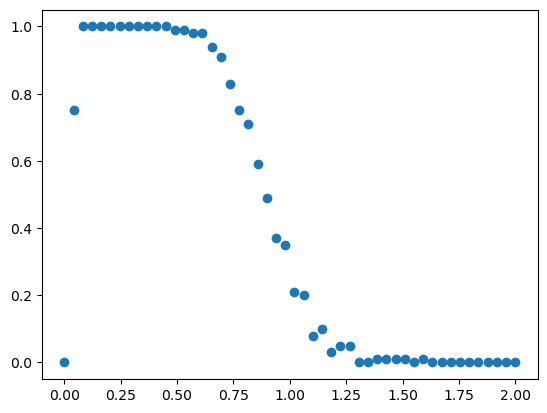

In [48]:
f,ax = plt.subplots()
ax.scatter(noise_levels, number_significant_bars)
plt.show()